In [1]:
import numpy as np
from skimage.draw import polygon_perimeter, line
from shapely.geometry import Polygon
from typing import Tuple, Optional


def _rotation(pts: np.ndarray, theta: float) -> np.ndarray:
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    pts = pts @ r
    return pts


def _make_box_pts(
    pos_x: float, pos_y: float, yaw: float, dim_x: float, dim_y: float
) -> np.ndarray:

    hx = dim_x / 2
    hy = dim_y / 2

    pts = np.asarray([(-hx, -hy), (-hx, hy), (hx, hy), (hx, -hy)])
    pts = _rotation(pts, yaw)
    pts += (pos_x, pos_y)
    return pts


def _make_spaceship(
    pos: np.asarray, yaw: float, scale: float, l2w: float, t2l: float
) -> Tuple[np.ndarray, np.ndarray]:

    dim_x = scale
    dim_y = scale * l2w

    # spaceship
    x1 = (0, dim_y)
    x2 = (-dim_x / 2, 0)
    x3 = (0, dim_y * t2l)
    x4 = (dim_x / 2, 0)
    pts = np.asarray([x1, x2, x3, x4])
    pts[:, 1] -= dim_y / 2

    # rotation + translation
    pts = _rotation(pts, yaw)
    pts += pos

    # label
    # pos_y, pos_x, yaw, dim_x, dim_y
    params = np.asarray([*pos, yaw, dim_x, dim_y])

    return pts, params


def _get_pos(s: float) -> np.ndarray:
    return np.random.randint(10, s - 10, size=2)


def _get_yaw() -> float:
    return np.random.rand() * 2 * np.pi


def _get_size() -> int:
    return np.random.randint(18, 37)


def _get_l2w() -> float:
    return abs(np.random.normal(3 / 2, 0.2))


def _get_t2l() -> float:
    return abs(np.random.normal(1 / 3, 0.1))


In [2]:
def make_data_v2(
    has_spaceship: bool = None,
    noise_level: float = 0.8,
    no_lines: int = 6,
    image_size: int = 200
):
    if has_spaceship is None:
        has_spaceship = np.random.choice([True, False], p=(0.8, 0.2))

    img = np.zeros(shape=(image_size, image_size))
    label = np.full(5, np.nan)

    # draw ship
    if has_spaceship:

        params = (_get_pos(image_size), _get_yaw(), _get_size(), _get_l2w(), _get_t2l())
        pts, label = _make_spaceship(*params)

        rr, cc = polygon_perimeter(pts[:, 0], pts[:, 1])
        valid = (rr >= 0) & (rr < image_size) & (cc >= 0) & (cc < image_size)

        img[rr[valid], cc[valid]] = np.random.rand(np.sum(valid))
    
    # noise lines
    line_noise = np.zeros(shape=(image_size, image_size))
    for _ in range(no_lines):
        rr, cc = line(*np.random.randint(0, 200, size=4))
        line_noise[rr, cc] = np.random.rand(rr.size)

    # static noise
    noise = noise_level * np.random.rand(image_size, image_size)
    images = {
        "spaceship": img.T,
        "noise": noise.T,
        "lines": line_noise.T,
        "noise+lines": np.stack([noise, line_noise], axis=0).max(axis=0).T,
        "spaceship+lines": np.stack([img, line_noise], axis=0).max(axis=0).T,
        "spaceship+noise": np.stack([img, noise], axis=0).max(axis=0).T,
        "img": np.stack([img, noise, line_noise], axis=0).max(axis=0).T,
    }

    return images, label

# Example Data and Plot

In [3]:
from helpers import make_data, _make_box_pts
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line

def plot(ax, img, label, title, make_dot=True, make_box=True):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)

    if label.size > 0:
        x, y, yaw, x_size, y_size = label

        if make_dot:
            ax.scatter(x, y, c="r")

        if make_box:
            xy = _make_box_pts(*label)
            ax.plot(xy[:, 0], xy[:, 1], c="r")

def pplot(images, processed, label):
    fig, ax = plt.subplots(1, 3, figsize=(20, 12))
    plot(ax[0], images["spaceship"], label, "spaceship", make_dot=True, make_box=True)
    plot(ax[1], images["img"], label, "img", make_dot=True, make_box=True)
    plot(ax[2], processed, label, "processed", make_dot=True, make_box=True)

In [4]:
# example data
images, label = make_data_v2(has_spaceship=True)

x:	21.0
y:	84.0
yaw:	0.39
width:	35.0
height:	63.4


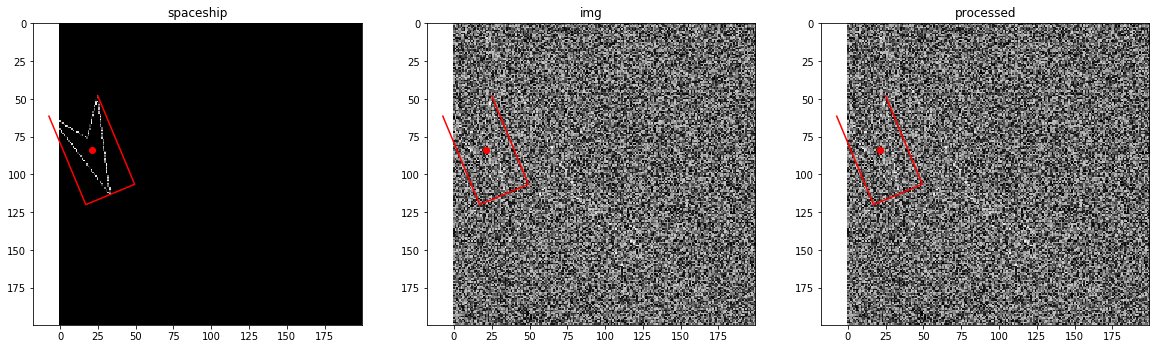

In [5]:
for i, k in enumerate(["x", "y", "yaw", "width", "height"]):
    print(f"{k}:\t{str(round(label[i], 2))}")
pplot(images, images["img"], label)

# Preprocessing

In [6]:
import cv2

In [7]:
def preprocess_and_plot(func):
    def wrapper(**kwargs):
        cvimg = np.array(images["img"] * 255, dtype = np.uint8)
        preprocessed = func(cvimg, **kwargs)
        return pplot(images, preprocessed, label)
    return wrapper

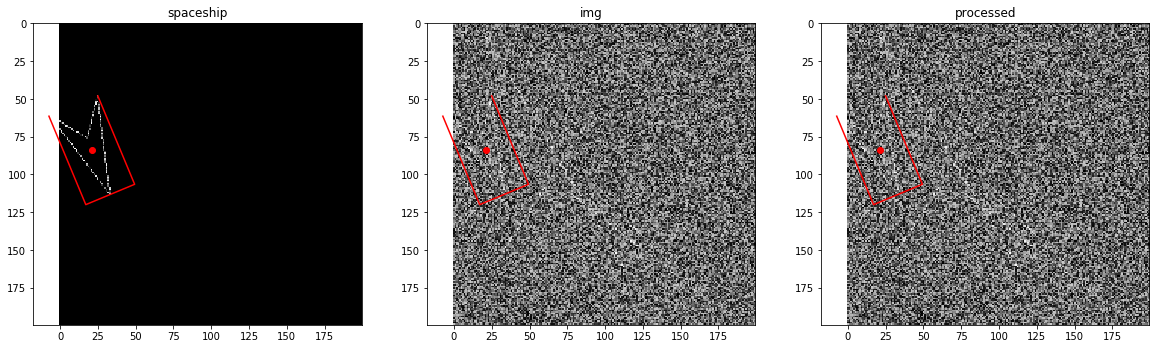

In [8]:
@preprocess_and_plot
def exp1(img):
    return cv2.medianBlur(img, 1)
exp1()

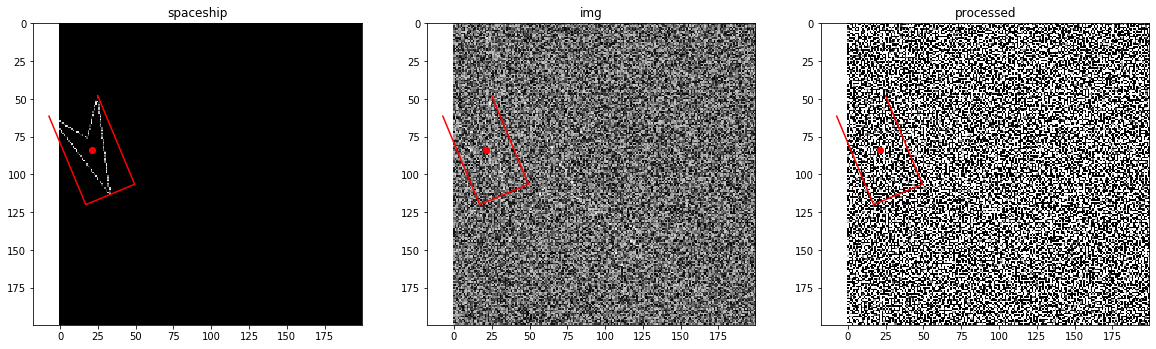

In [9]:
@preprocess_and_plot
def exp2(img):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(img, -1, kernel)
exp2()

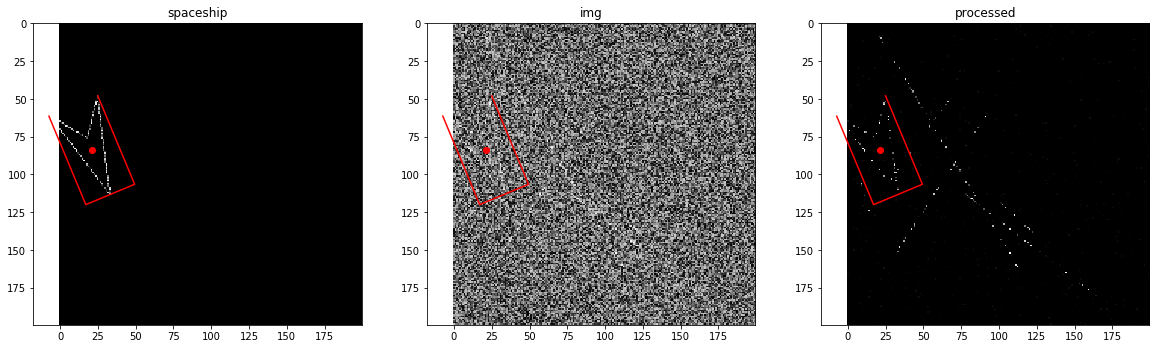

In [10]:
@preprocess_and_plot
def exp3(img):
    return cv2.add(img, -200)
exp3()

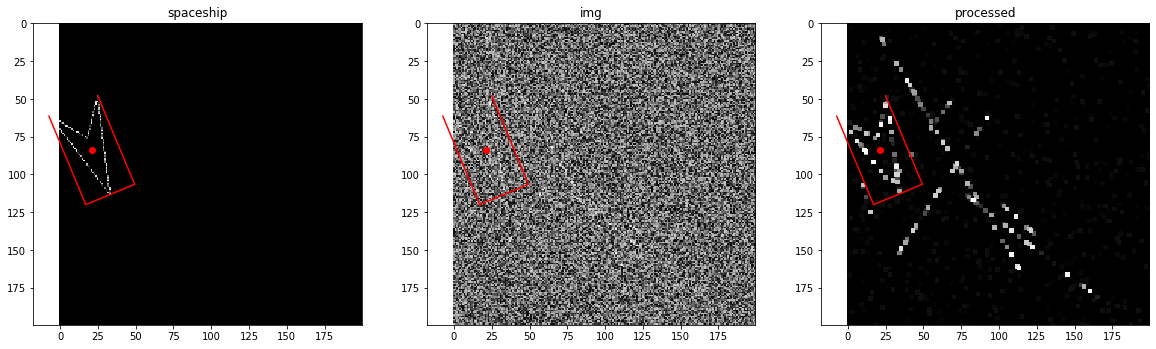

In [11]:
@preprocess_and_plot
def exp4(img):
    img = cv2.add(img, -200)
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations = 2)
    return img
exp4()

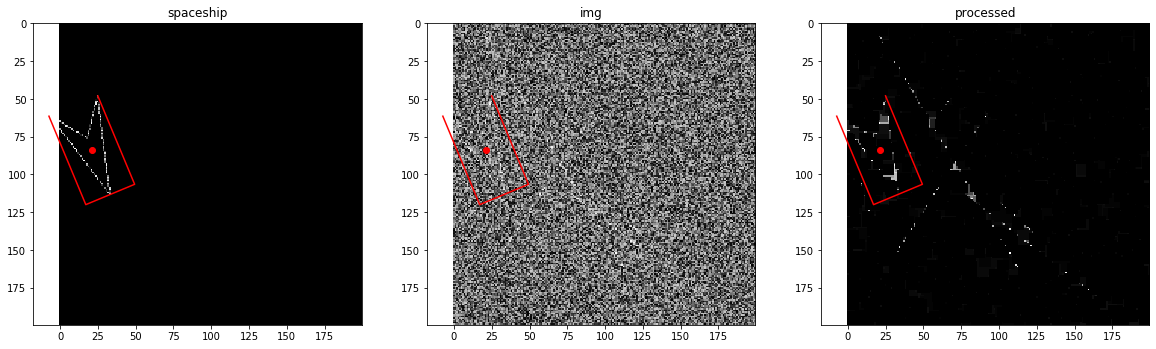

In [12]:
@preprocess_and_plot
def exp5(img):
    img = cv2.add(img, -200)
    kernel = np.ones((3,3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=3)
    img = cv2.erode(img, kernel, iterations=3)
    return img
exp5()

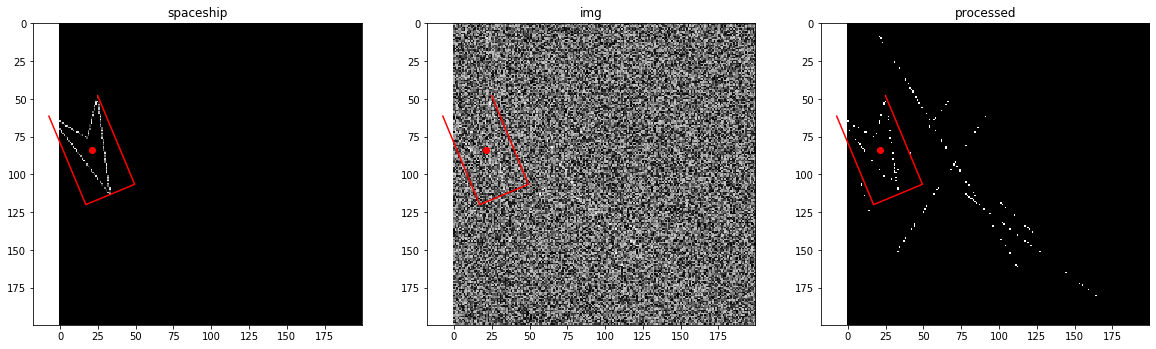

In [13]:
@preprocess_and_plot
def exp6(img):
    img = cv2.add(img, -200)
    lower = np.array(5, dtype=np.uint8)
    upper = np.array(255, dtype=np.uint8)
    img = cv2.inRange(img, lower, upper)
    return img
exp6()

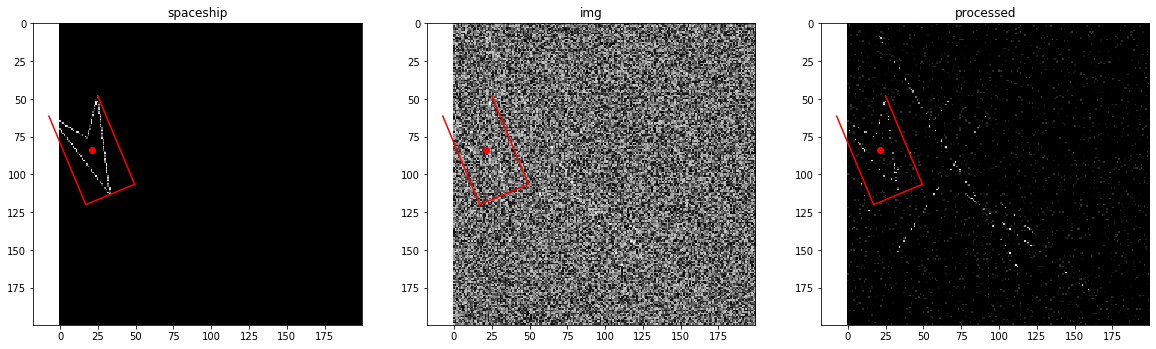

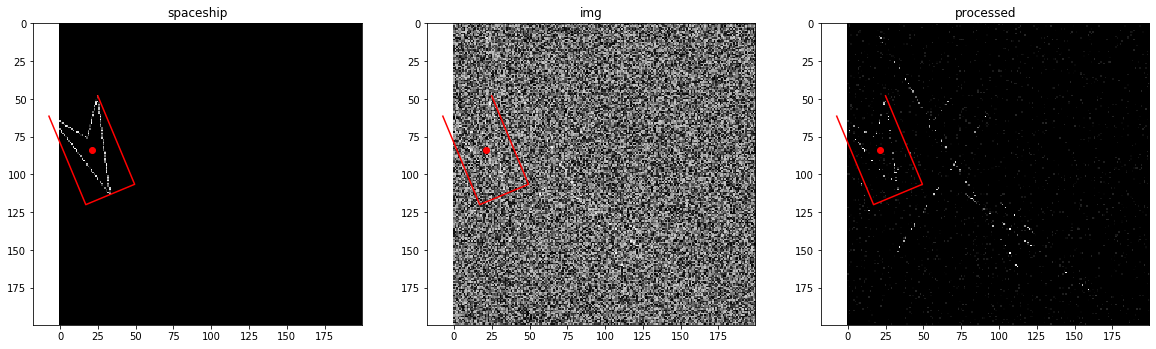

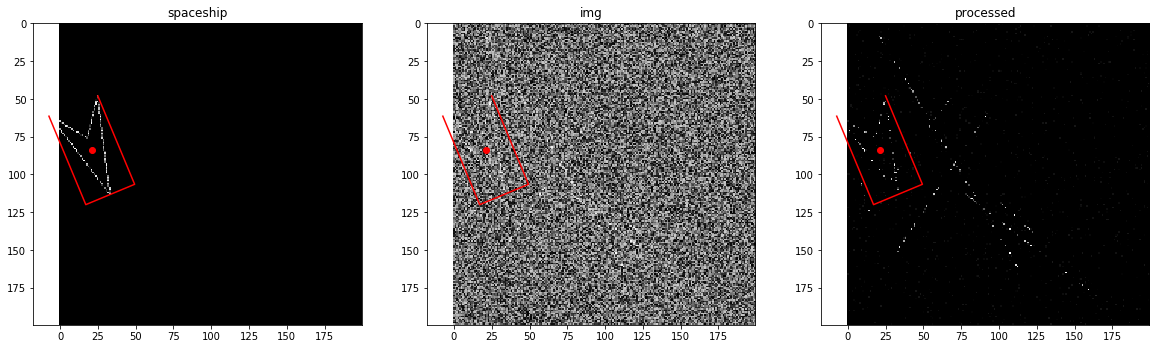

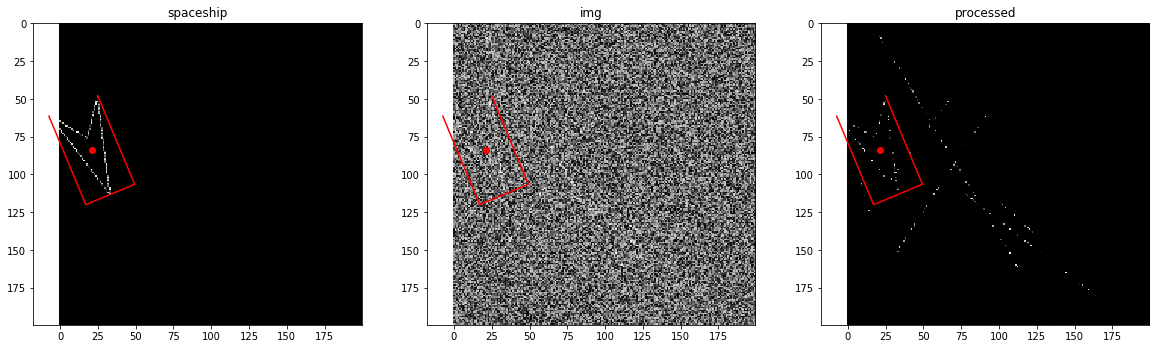

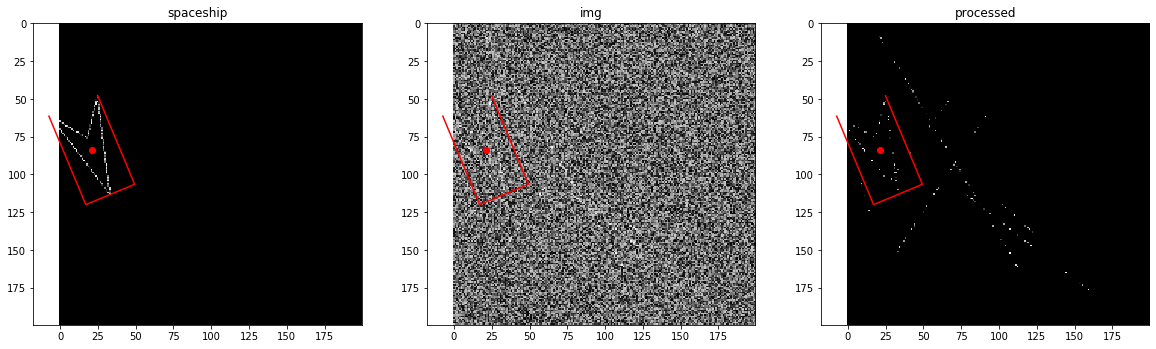

In [14]:
@preprocess_and_plot
def exp7(img):
    return cv2.add(img, -val)

for val in range(190, 210, 4):
    plt.show(exp7())

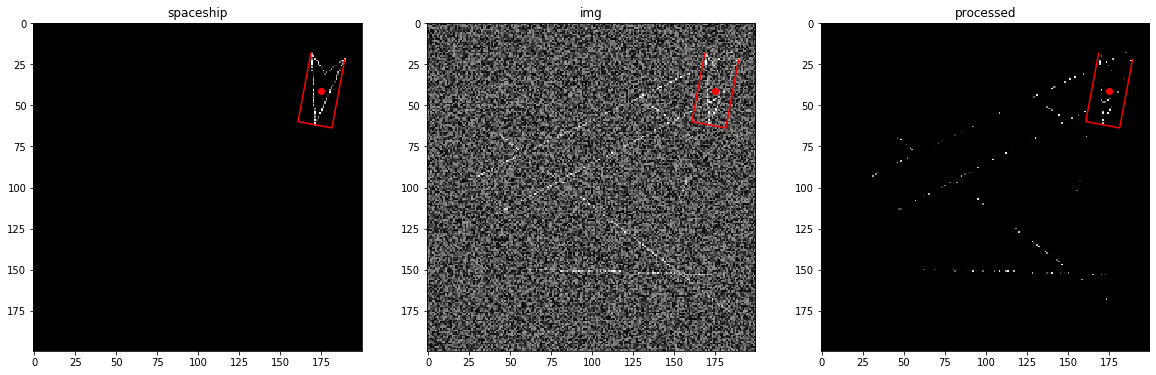

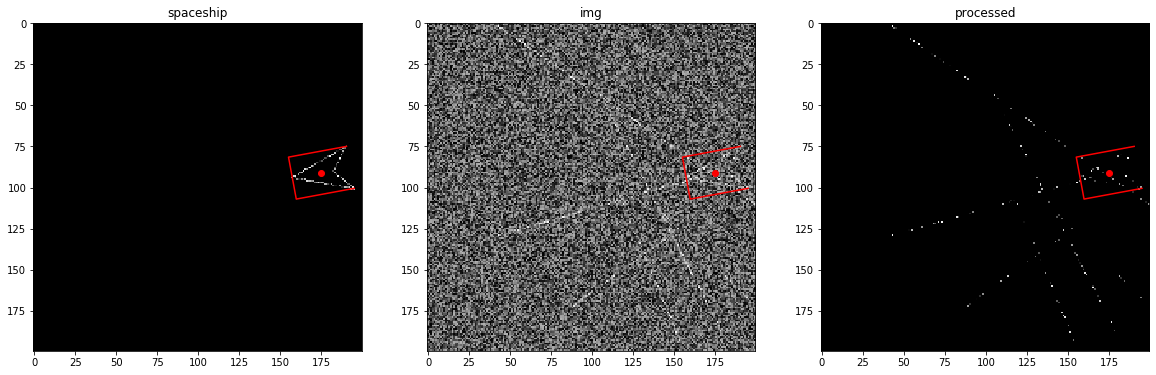

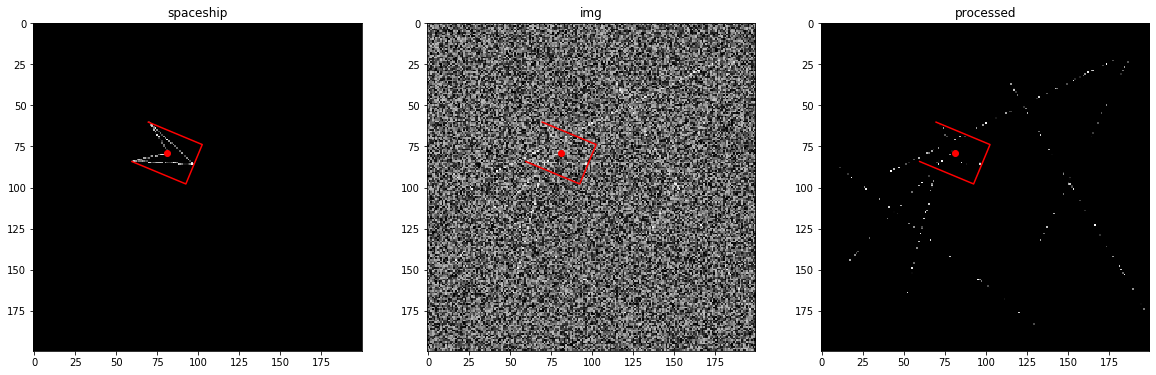

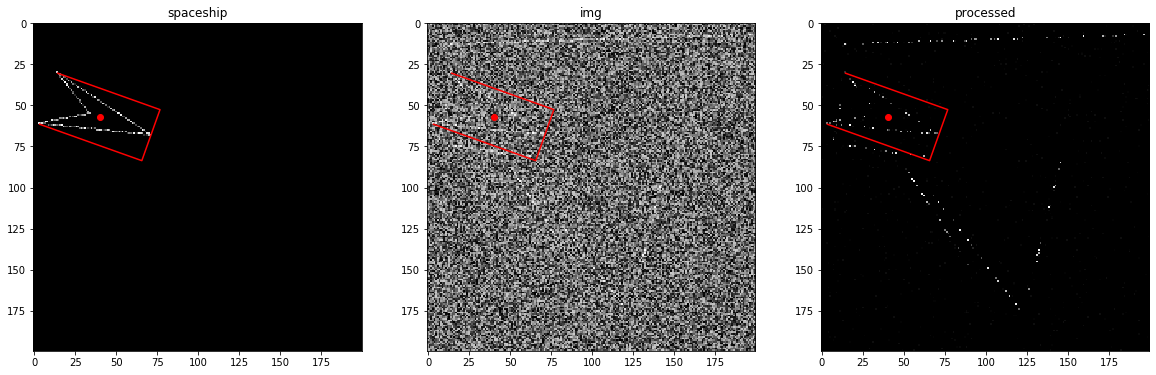

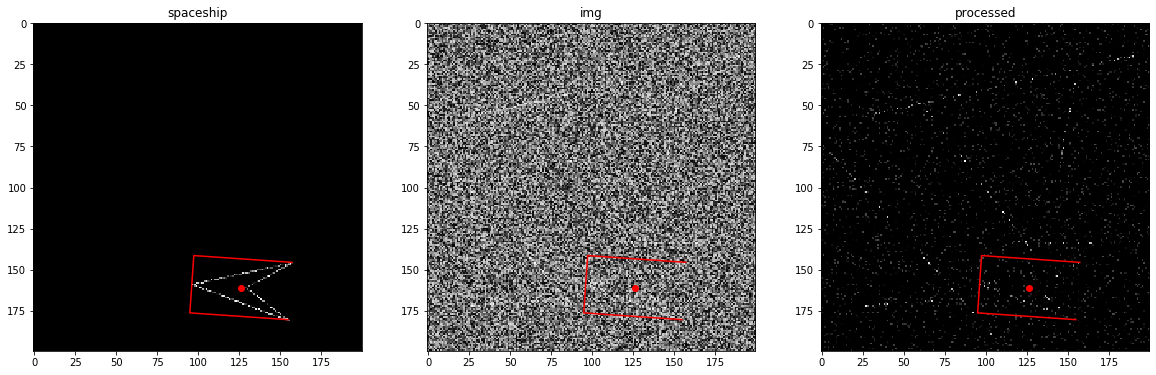

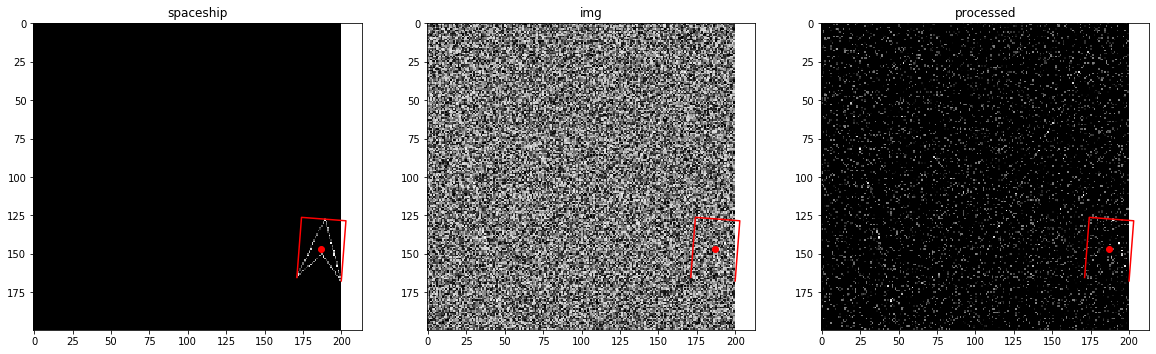

In [15]:
@preprocess_and_plot
def exp8(img):
    return cv2.add(img, -200)

for noise in [.6, .7, .75, .8, .85, .9]:
    images, label = make_data_v2(has_spaceship=True, noise_level=noise)
    plt.show(exp8())

# Best Preproc

In [1]:
from helpers import make_data
import cv2
import numpy as np

In [2]:
img, label = make_data(has_spaceship=True)

In [3]:
# convert to uint8
img = np.array(img*255, dtype=np.uint8)

# -200 is best for noise_level=0.8, ideally it would be scaled 
# with noise_level to reduce lost information on lower noise 
# levels and reduce noisyness on hight noise levels
cv2.add(img, -200)
img = cv2.add(img, -200)

# convert all non-black pixels to 255
lower = np.array(5, dtype=np.uint8)
upper = np.array(255, dtype=np.uint8)
img = cv2.inRange(img, lower, upper)

# convert back to float
img = np.array(img, dtype=np.float32) / 255

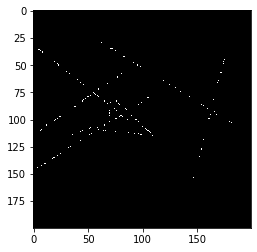

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap="gray")

In [5]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
set([x for r in img for x in r])

{0.0, 1.0}